In [2]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 0
RUN_IMPORTANCES = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 1000)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

learning_disorder_cols = [
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    "Diag: Specific Learning Disorder with Impairment in Written Expression"
]

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ") and item_lvl_w_imp[x].sum() > 70] # All diagnosis columns
display(diag_cols)

['Diag: Specific Phobia',
 'Diag: Specific Learning Disorder with Impairment in Reading',
 'Diag: Oppositional Defiant Disorder',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: No Diagnosis Given',
 'Diag: Major Depressive Disorder',
 'Diag: Enuresis',
 'Diag: Generalized Anxiety Disorder',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: ADHD-Combined Type',
 'Diag: Language Disorder',
 'Diag: Separation Anxiety',
 'Diag: ADHD-Inattentive Type',
 'Diag: Autism Spectrum Disorder',
 'Diag: Specific Learning Disorder with Impairment in Written Expression']

In [3]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col, X_train, y_train):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(X_train, y_train) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [4]:
def find_best_classifier_for_diag(diag, X_train, y_train):
    base_models_and_param_grids = get_base_models_and_param_grids()
    best_classifiers_and_scores = []
    
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag, X_train, y_train)
        model_type = list(base_model.named_steps.keys())[-1]
        best_classifiers_and_scores.append([model_type, best_classifier_for_model, best_score_for_model])
    
    best_classifiers_and_scores = pd.DataFrame(best_classifiers_and_scores, columns = ["Model type", "Best classifier", "Best score"])
    display(best_classifiers_and_scores)
    best_classifier = best_classifiers_and_scores.sort_values("Best score", ascending=False)["Best classifier"].iloc[0]
    
    # If LogisticRegression is not much worse than the best model, prefer LogisticRegression (much faster than rest)
    best_base_model = best_classifiers_and_scores[best_classifiers_and_scores["Best classifier"] == best_classifier]["Model type"].iloc[0]
    if best_base_model != "logisticregression":
        best_score = best_classifiers_and_scores[best_classifiers_and_scores["Best classifier"] == best_classifier]["Best score"].iloc[0]
        lr_score = best_classifiers_and_scores[best_classifiers_and_scores["Model type"] == "logisticregression"]["Best score"].iloc[0]
        print("lr_score: ", lr_score, "; best_score: ", best_score)
        e = 0.03
        if best_score - lr_score <= e:
            best_classifier = best_classifiers_and_scores[best_classifiers_and_scores["Model type"] == "logisticregression"]["Best classifier"].iloc[0]
        
    print("best classifier:")
    print(best_classifier)
    
    return best_classifier

In [5]:
# Create datasets for each diagnosis (different input and output columns)

def get_input_and_output_cols_for_diag(diag):
    
    input_cols = [x for x in item_lvl_w_imp.columns if 
                        not x.startswith("WIAT")
                        and not x.startswith("WISC")
                        and not x in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]
                        and not x in diag_cols
                        and not x.startswith("NIH")
                 ]
    
    output_col = diag
    
    return input_cols, output_col

datasets = {}
for diag in diag_cols:
    
    input_cols, output_col = get_input_and_output_cols_for_diag(diag)
    
    # Split train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(item_lvl_w_imp[input_cols], item_lvl_w_imp[output_col], test_size=0.3, random_state=1)
    X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1) 

    datasets[diag] = { "X_train": X_train,
                       "X_test": X_test,
                       "y_train": y_train,
                       "y_test": y_test,
                       "X_train_train": X_train_train,
                       "X_val": X_val,
                       "y_train_train": y_train_train,
                       "y_val": y_val}

In [6]:
# Calculate probability threshold
beta = 2
def calculate_threshold(classifier, X_train_train, y_train_train, X_val, y_val, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(X_train_train, y_train_train)
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(X_val)
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [7]:
# Find best classifier
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for diag in diag_cols:
        print(diag)

        X_train = datasets[diag]["X_train"]
        y_train = datasets[diag]["y_train"]
        
        best_classifier_for_diag = find_best_classifier_for_diag(diag, X_train, y_train)
        best_classifiers[diag] = best_classifier_for_diag
    print(best_classifiers)

In [8]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in best_classifiers:
        print(diag)
        best_classifier_for_diag = best_classifiers[diag]
        X_train_train, y_train_train, X_val, y_val = datasets[diag]["X_train_train"], datasets[diag]["y_train_train"], datasets[diag]["X_val"], datasets[diag]["y_val"]
        threshold = calculate_threshold(best_classifier_for_diag, X_train_train, y_train_train, X_val, y_val, beta)
        best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

In [9]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds 
    dump(best_classifiers, 'best-classifiers-cons-new-item-lvl.joblib', compress=1)
    dump(best_thresholds, 'best-thresholds-cons-new-item-lvl.joblib', compress=1)

In [10]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best-classifiers-cons-new-item-lvl.joblib')
    best_thresholds = load('best-thresholds-cons-new-item-lvl.joblib')

In [11]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall (Sensitivity)','FPR','FNR','TNR (Specificity)','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK','Predicted Positive Ratio']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FN) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    #DOR        = 1 # FIX, LINE ABOVE
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    Predicted_Positive_Ratio = round( (TP+FP) / Population,2)
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK,Predicted_Positive_Ratio]
    return (mat_met)

In [12]:
def get_metrics(classifier, threshold, X, y, print_output_flag = 0):
       
    y_pred_prob = classifier.predict_proba(X)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
        display = PrecisionRecallDisplay.from_predictions(y, y_pred_prob[:,1])
        display.ax_.set_title("Precision-Recall curve")
        plt.scatter(metrics[metric_names.index("Recall (Sensitivity)")], metrics[metric_names.index("Precision")], marker='o', color='black', label='Best')
        plt.show()
        
    return metrics

Diag: Specific Phobia


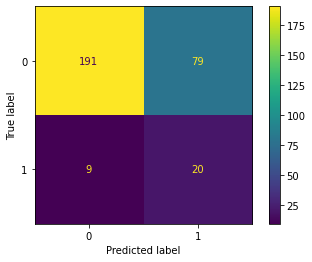

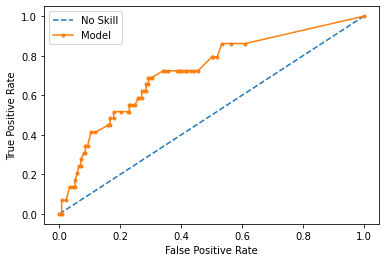

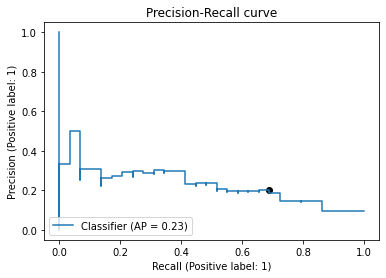

Diag: Specific Learning Disorder with Impairment in Reading


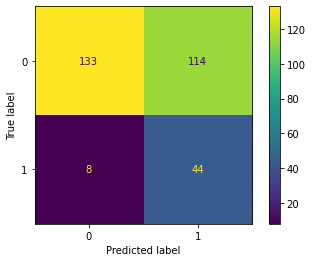

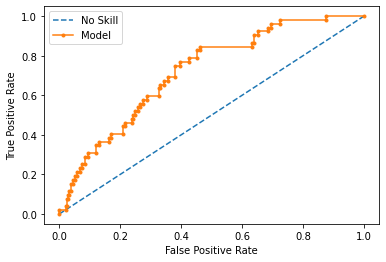

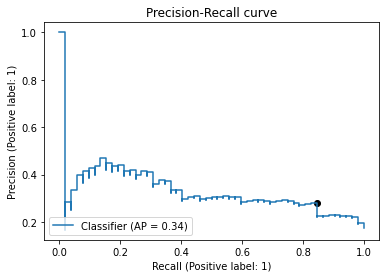

Diag: Oppositional Defiant Disorder


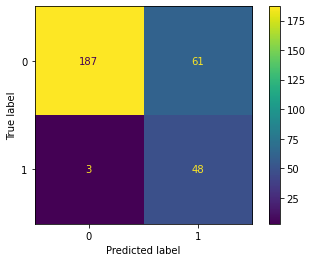

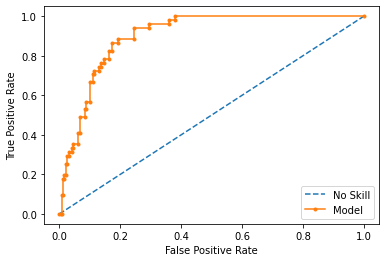

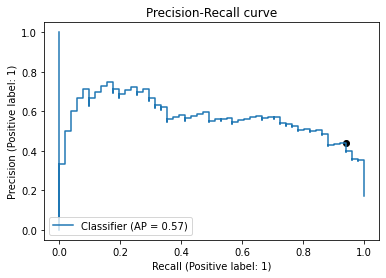

Diag: Specific Learning Disorder with Impairment in Mathematics


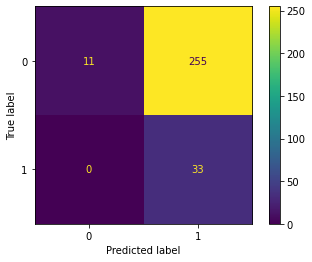

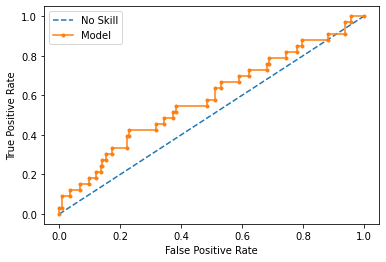

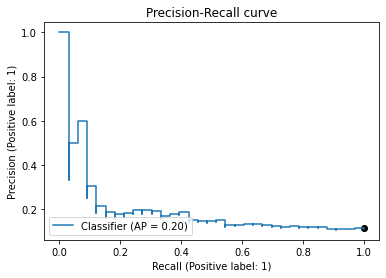

Diag: No Diagnosis Given


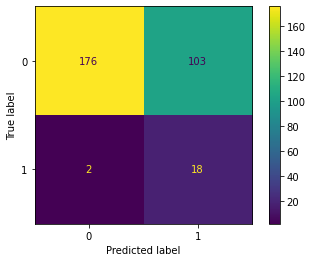

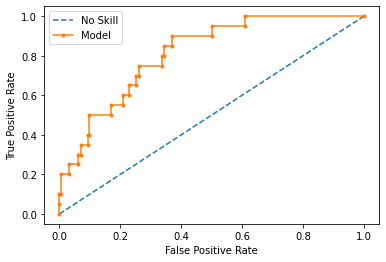

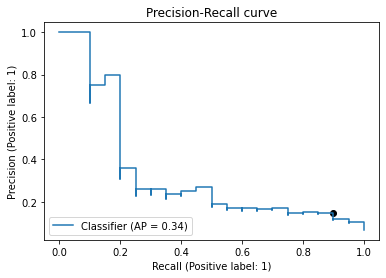

Diag: Major Depressive Disorder


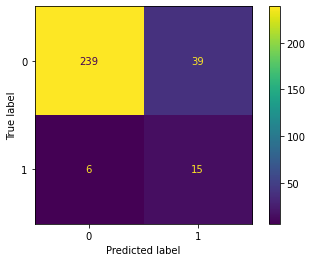

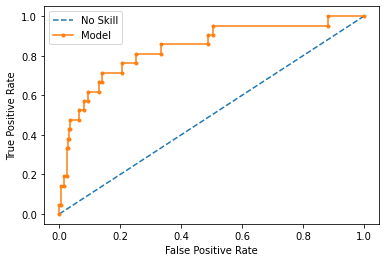

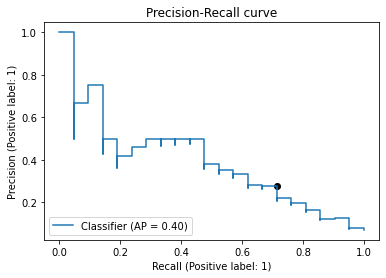

Diag: Enuresis


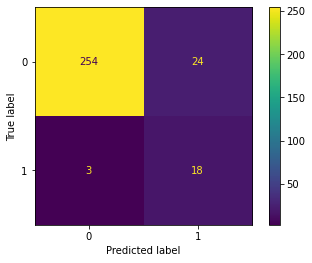

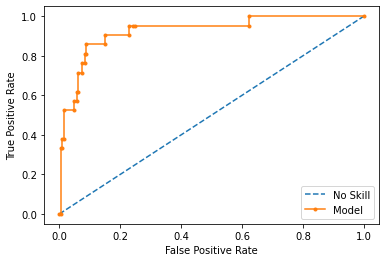

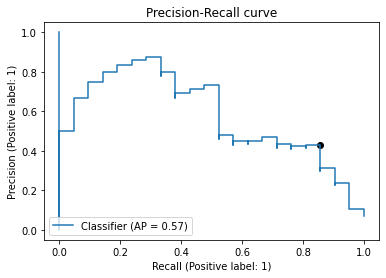

Diag: Generalized Anxiety Disorder


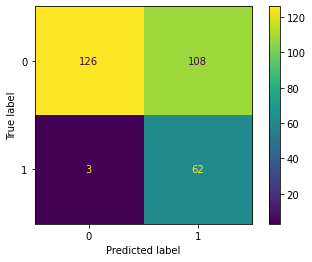

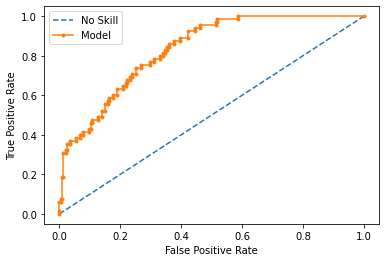

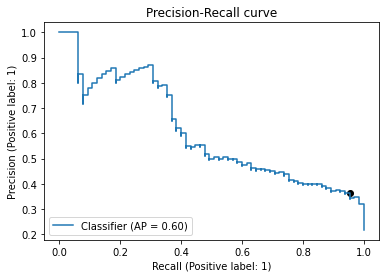

Diag: Social Anxiety (Social Phobia)


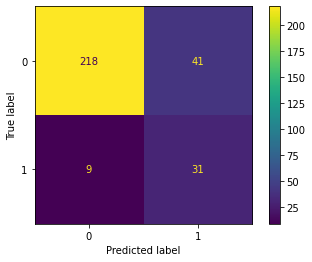

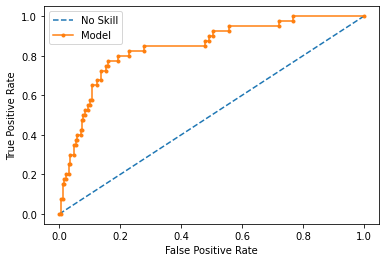

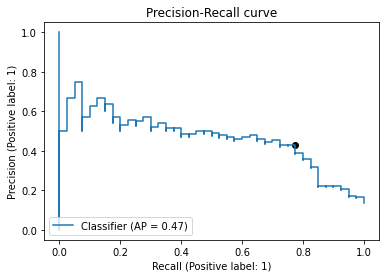

Diag: ADHD-Combined Type


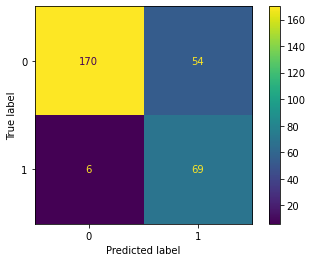

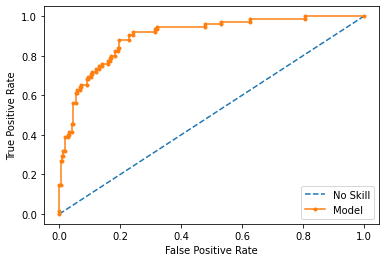

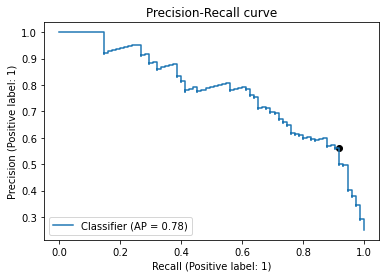

Diag: Language Disorder


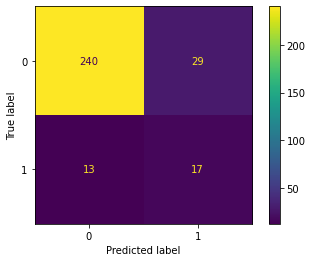

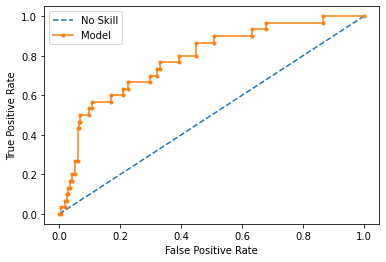

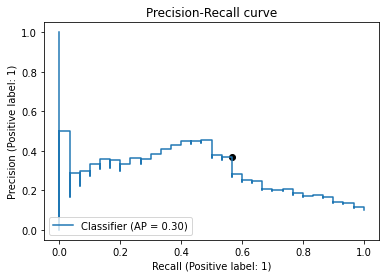

Diag: Separation Anxiety


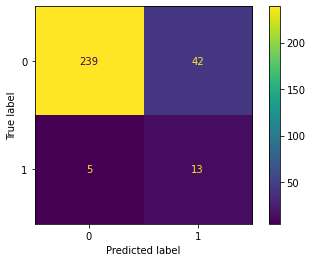

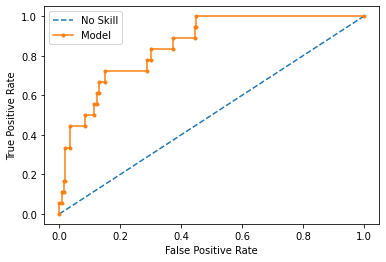

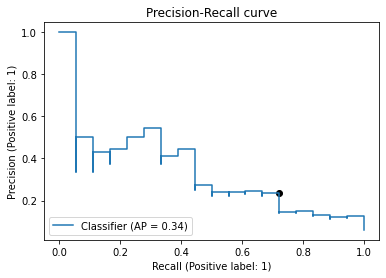

Diag: ADHD-Inattentive Type


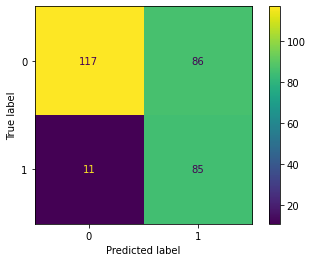

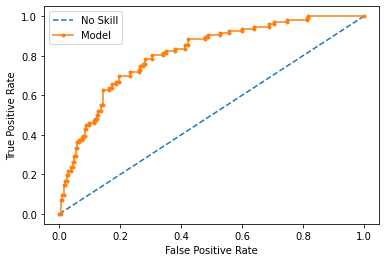

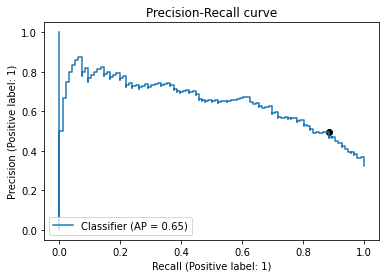

Diag: Autism Spectrum Disorder


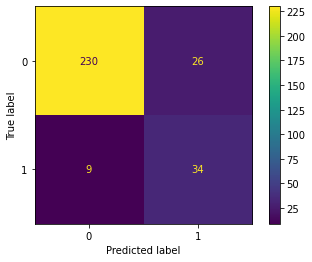

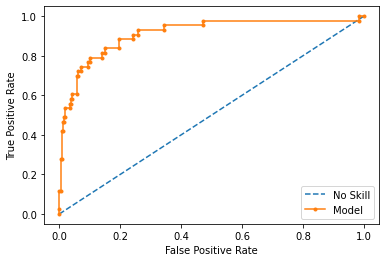

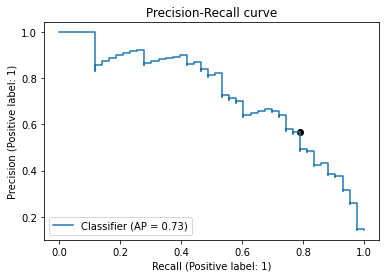

Diag: Specific Learning Disorder with Impairment in Written Expression


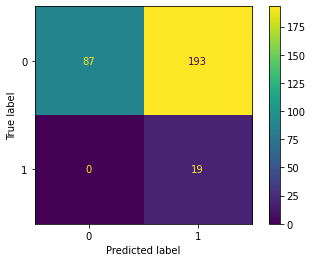

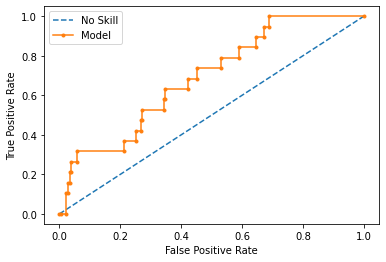

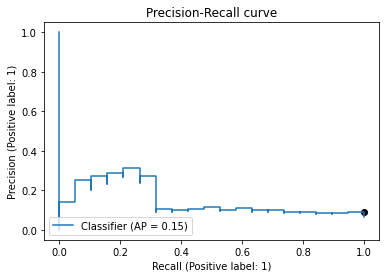

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall (Sensitivity),FPR,FNR,TNR (Specificity),check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,Predicted Positive Ratio,ROC AUC
6,Diag: Enuresis,18.01,254.01,24.01,3.01,0.07,0.91,0.43,0.99,0.57,1.17e-02,1.0,1.0,0.86,0.09,1.43e-01,0.91,1.0,1.0,9.92,1.57e-01,63,0.57,0.78,0.57,0.77,0.42,0.14,0.93
13,Diag: Autism Spectrum Disorder,34.01,230.01,26.01,9.01,0.14,0.88,0.57,0.96,0.43,3.77e-02,1.0,1.0,0.79,0.10,2.09e-01,0.90,1.0,1.0,7.78,2.33e-01,33,0.66,0.76,0.60,0.69,0.53,0.20,0.91
2,Diag: Oppositional Defiant Disorder,48.01,187.01,61.01,3.01,0.17,0.79,0.44,0.98,0.56,1.58e-02,1.0,1.0,0.94,0.25,5.90e-02,0.75,1.0,1.0,3.83,7.82e-02,49,0.60,0.84,0.54,0.69,0.42,0.36,0.90
9,Diag: ADHD-Combined Type,69.01,170.01,54.01,6.01,0.25,0.80,0.56,0.97,0.44,3.41e-02,1.0,1.0,0.92,0.24,8.01e-02,0.76,1.0,1.0,3.82,1.05e-01,36,0.70,0.86,0.60,0.68,0.53,0.41,0.90
11,Diag: Separation Anxiety,13.01,239.01,42.01,5.01,0.06,0.84,0.24,0.98,0.76,2.05e-02,1.0,1.0,0.72,0.15,2.78e-01,0.85,1.0,1.0,4.83,3.27e-01,15,0.36,0.60,0.35,0.57,0.22,0.18,0.86
8,Diag: Social Anxiety (Social Phobia),31.01,218.01,41.01,9.01,0.13,0.83,0.43,0.96,0.57,3.97e-02,1.0,1.0,0.77,0.16,2.25e-01,0.84,1.0,1.0,4.90,2.67e-01,18,0.55,0.72,0.49,0.62,0.39,0.24,0.84
5,Diag: Major Depressive Disorder,15.01,239.01,39.01,6.01,0.07,0.85,0.28,0.98,0.72,2.45e-02,1.0,1.0,0.71,0.14,2.86e-01,0.86,1.0,1.0,5.09,3.33e-01,15,0.40,0.62,0.38,0.57,0.25,0.18,0.84
7,Diag: Generalized Anxiety Disorder,62.01,126.01,108.01,3.01,0.22,0.63,0.36,0.98,0.64,2.33e-02,1.0,1.0,0.95,0.46,4.63e-02,0.54,1.0,1.0,2.07,8.60e-02,24,0.53,0.82,0.41,0.49,0.34,0.57,0.83
4,Diag: No Diagnosis Given,18.01,176.01,103.01,2.01,0.07,0.65,0.15,0.99,0.85,1.13e-02,1.0,1.0,0.90,0.37,1.00e-01,0.63,1.0,1.0,2.44,1.59e-01,15,0.26,0.60,0.27,0.53,0.14,0.40,0.81
12,Diag: ADHD-Inattentive Type,85.01,117.01,86.01,11.01,0.32,0.68,0.50,0.91,0.50,8.60e-02,1.0,1.0,0.89,0.42,1.15e-01,0.58,1.0,1.0,2.09,1.99e-01,10,0.64,0.82,0.44,0.46,0.41,0.57,0.81


In [13]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in best_classifiers:
    print(diag)
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    X_val, y_val = datasets[diag]["X_val"], datasets[diag]["y_val"]
    metrics = get_metrics(classifier, threshold, X_val, y_val, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_val_set.append([
        diag, 
        *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [14]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in best_classifiers:
    
    print(diag)
    
    classifier = best_classifiers[diag]

    cv = StratifiedKFold(n_splits=5)
    X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
    auc = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

    auc_cv_mean_val_set.append(auc.mean())
    auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

Diag: Specific Phobia
Diag: Specific Learning Disorder with Impairment in Reading
Diag: Oppositional Defiant Disorder
Diag: Specific Learning Disorder with Impairment in Mathematics
Diag: No Diagnosis Given
Diag: Major Depressive Disorder
Diag: Enuresis
Diag: Generalized Anxiety Disorder
Diag: Social Anxiety (Social Phobia)
Diag: ADHD-Combined Type
Diag: Language Disorder
Diag: Separation Anxiety
Diag: ADHD-Inattentive Type
Diag: Autism Spectrum Disorder
Diag: Specific Learning Disorder with Impairment in Written Expression


,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall (Sensitivity),FPR,FNR,TNR (Specificity),check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,Predicted Positive Ratio,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,Diag: Specific Phobia,20.01,191.01,79.01,9.01,0.10,0.71,0.20,0.95,0.80,4.50e-02,1.0,1.0,0.69,0.29,3.10e-01,0.71,1.0,1.0,2.36,4.39e-01,5,0.31,0.56,0.25,0.40,0.16,0.33,0.72,0.72,0.07
1,Diag: Specific Learning Disorder with Impairment in Reading,44.01,133.01,114.01,8.01,0.17,0.59,0.28,0.94,0.72,5.68e-02,1.0,1.0,0.85,0.46,1.54e-01,0.54,1.0,1.0,1.83,2.86e-01,6,0.42,0.70,0.29,0.38,0.22,0.53,0.72,0.80,0.03
2,Diag: Oppositional Defiant Disorder,48.01,187.01,61.01,3.01,0.17,0.79,0.44,0.98,0.56,1.58e-02,1.0,1.0,0.94,0.25,5.90e-02,0.75,1.0,1.0,3.83,7.82e-02,49,0.60,0.84,0.54,0.69,0.42,0.36,0.90,0.88,0.03
3,Diag: Specific Learning Disorder with Impairment in Mathematics,33.01,11.01,255.01,0.01,0.11,0.15,0.11,1.00,0.89,9.00e-04,1.0,1.0,1.00,0.96,3.00e-04,0.04,1.0,1.0,1.04,7.20e-03,145,0.21,0.56,0.07,0.04,0.11,0.96,0.59,0.63,0.03
4,Diag: No Diagnosis Given,18.01,176.01,103.01,2.01,0.07,0.65,0.15,0.99,0.85,1.13e-02,1.0,1.0,0.90,0.37,1.00e-01,0.63,1.0,1.0,2.44,1.59e-01,15,0.26,0.60,0.27,0.53,0.14,0.40,0.81,0.82,0.04
5,Diag: Major Depressive Disorder,15.01,239.01,39.01,6.01,0.07,0.85,0.28,0.98,0.72,2.45e-02,1.0,1.0,0.71,0.14,2.86e-01,0.86,1.0,1.0,5.09,3.33e-01,15,0.40,0.62,0.38,0.57,0.25,0.18,0.84,0.85,0.05
6,Diag: Enuresis,18.01,254.01,24.01,3.01,0.07,0.91,0.43,0.99,0.57,1.17e-02,1.0,1.0,0.86,0.09,1.43e-01,0.91,1.0,1.0,9.92,1.57e-01,63,0.57,0.78,0.57,0.77,0.42,0.14,0.93,0.87,0.07
7,Diag: Generalized Anxiety Disorder,62.01,126.01,108.01,3.01,0.22,0.63,0.36,0.98,0.64,2.33e-02,1.0,1.0,0.95,0.46,4.63e-02,0.54,1.0,1.0,2.07,8.60e-02,24,0.53,0.82,0.41,0.49,0.34,0.57,0.83,0.82,0.03
8,Diag: Social Anxiety (Social Phobia),31.01,218.01,41.01,9.01,0.13,0.83,0.43,0.96,0.57,3.97e-02,1.0,1.0,0.77,0.16,2.25e-01,0.84,1.0,1.0,4.90,2.67e-01,18,0.55,0.72,0.49,0.62,0.39,0.24,0.84,0.83,0.02
9,Diag: ADHD-Combined Type,69.01,170.01,54.01,6.01,0.25,0.80,0.56,0.97,0.44,3.41e-02,1.0,1.0,0.92,0.24,8.01e-02,0.76,1.0,1.0,3.82,1.05e-01,36,0.70,0.86,0.60,0.68,0.53,0.41,0.90,0.89,0.02


In [33]:
for diag in best_classifiers:
    print(diag)
    print(list(best_classifiers[diag].named_steps.keys())[-1])
    if list(best_classifiers[diag].named_steps.keys())[-1] == "randomforestclassifier":
        importances = best_classifiers[diag].named_steps[list(best_classifiers[diag].named_steps.keys())[-1]].feature_importances_
        X_train = datasets[diag]["X_train"]
        importances = pd.DataFrame(zip(X_train.columns, importances), columns=["Feature", "Importance"])
        pd.set_option('display.precision', 2)
        display(importances.sort_values(by="Importance", ascending=False).iloc[0:10])
        #display(importances[importances["Feature"].str.startswith("NIH")].sort_values(by="Importance", ascending=False).iloc[0:1000])
    else:
        importances = best_classifiers[diag].named_steps[list(best_classifiers[diag].named_steps.keys())[-1]].coef_
        X_train = datasets[diag]["X_train"]
        importances = pd.DataFrame(zip(X_train.columns, abs(importances[0]), importances[0]>0), columns=["Feature", "Importance", "Positive"])
        pd.set_option('display.precision', 2)
        display(importances.sort_values(by="Importance", ascending=False).iloc[0:10])
        #display(importances[importances["Feature"].str.startswith("NIH")].sort_values(by="Importance", ascending=False).iloc[0:1000])

Diag: Specific Phobia
logisticregression


,Feature,Importance,Positive
45,"SympChck,CSC_22P",1.46e-01,True
359,"CBCL,CBCL_29",1.03e-01,True
44,"SympChck,CSC_22C",4.69e-02,True
226,"SDQ,SDQ_24",2.83e-02,True
189,"ASSQ,ASSQ_21",1.51e-02,True
794,"RBS,RBS_40",1.21e-03,True
665,"APQ_SR,APQ_SR_19",0.00e+00,False
667,"APQ_SR,APQ_SR_20A",0.00e+00,False
666,"APQ_SR,APQ_SR_20",0.00e+00,False
664,"APQ_SR,APQ_SR_18",0.00e+00,False


Diag: Specific Learning Disorder with Impairment in Reading
logisticregression


,Feature,Importance,Positive
909,"C3SR,C3SR_33",0.67,True
889,"C3SR,C3SR_13",0.28,True
914,"C3SR,C3SR_38",0.28,False
736,"PSI,PSI_18",0.17,True
384,"CBCL,CBCL_54",0.11,False
650,"APQ_SR,APQ_SR_08",0.11,True
818,"CIS_SR,CIS_SR_02",0.10,False
506,"PCIAT,PCIAT_04",0.09,False
978,Diag: Developmental Coordination Disorder,0.09,True
774,"RBS,RBS_20",0.08,False


Diag: Oppositional Defiant Disorder
logisticregression


,Feature,Importance,Positive
86,"SympChck,CSC_43C",0.02,True
79,"SympChck,CSC_39P",0.02,True
87,"SympChck,CSC_43P",0.02,True
440,"ICU_P,ICU_P_04",0.02,True
345,"CBCL,CBCL_15",0.02,True
356,"CBCL,CBCL_26",0.02,True
351,"CBCL,CBCL_21",0.02,True
352,"CBCL,CBCL_22",0.02,True
742,"PSI,PSI_24",0.01,True
89,"SympChck,CSC_44P",0.01,True


Diag: Specific Learning Disorder with Impairment in Mathematics
logisticregression


,Feature,Importance,Positive
914,"C3SR,C3SR_38",0.05,True
451,"ICU_P,ICU_P_15",0.05,False
949,Diag: Panic Disorder,0.04,True
986,Diag: Other Specified Depressive Disorder,0.04,True
736,"PSI,PSI_18",0.04,True
832,"SCARED_SR,SCARED_SR_03",0.04,False
961,Diag: Agoraphobia,0.04,True
456,"ICU_P,ICU_P_20",0.04,False
972,Diag: Cyclothymic Disorder,0.04,True
278,"SRS,SRS_25",0.04,False


Diag: No Diagnosis Given
logisticregression


,Feature,Importance,Positive
71,"SympChck,CSC_35P",5.22e-03,False
69,"SympChck,CSC_34P",5.10e-03,False
68,"SympChck,CSC_34C",5.05e-03,False
578,"ESWAN,MDD_8A",4.94e-03,False
446,"ICU_P,ICU_P_10",4.61e-03,True
325,"CBCL,CBCL_08",4.28e-03,False
70,"SympChck,CSC_35C",4.27e-03,False
583,"ESWAN,Panic_A02A",4.08e-03,False
860,"SCARED_SR,SCARED_SR_31",4.06e-03,True
885,"C3SR,C3SR_09",3.91e-03,False


Diag: Major Depressive Disorder
logisticregression


,Feature,Importance,Positive
3,"SympChck,CSC_01P",0.53,True
1,"Basic_Demos,Sex",0.28,True
709,"CIS_P,CIS_P_04",0.25,True
230,"SDQ,SDQ_28",0.24,True
61,"SympChck,CSC_30P",0.19,True
640,"APQ_SR,APQ_SR_01",0.17,True
285,"SRS,SRS_32",0.17,True
647,"APQ_SR,APQ_SR_06",0.17,True
959,Diag: Persistent Depressive Disorder (Dysthymia),0.15,True
105,"SympChck,CSC_52P",0.15,True


Diag: Enuresis
logisticregression


,Feature,Importance,Positive
336,"CBCL,CBCL_108",0.77,True
57,"SympChck,CSC_28P",0.38,True
27,"SympChck,CSC_13P",0.14,True
905,"C3SR,C3SR_29",0.12,True
626,"MFQ_P,MFQ_P_21",0.12,False
124,"SympChck,CSC_55hC",0.11,True
297,"SRS,SRS_44",0.10,False
189,"ASSQ,ASSQ_21",0.10,True
438,"ICU_P,ICU_P_02",0.10,False
980,Diag: Substance/Medication-Induced Bipolar and Related Disorder,0.09,True


Diag: Generalized Anxiety Disorder
logisticregression


,Feature,Importance,Positive
210,"SDQ,SDQ_08",0.27,True
341,"CBCL,CBCL_112",0.25,True
47,"SympChck,CSC_23P",0.22,True
713,"CIS_P,CIS_P_08",0.18,True
963,Diag: Other Specified Anxiety Disorder,0.15,False
774,"RBS,RBS_20",0.10,True
55,"SympChck,CSC_27P",0.09,True
709,"CIS_P,CIS_P_04",0.09,True
219,"SDQ,SDQ_17",0.08,True
911,"C3SR,C3SR_35",0.07,True


Diag: Social Anxiety (Social Phobia)
logisticregression


,Feature,Importance,Positive
40,"SympChck,CSC_20C",0.33,True
412,"CBCL,CBCL_75",0.24,True
251,"SWAN,SWAN_16",0.22,False
408,"CBCL,CBCL_71",0.22,True
80,"SympChck,CSC_40C",0.21,False
9,"SympChck,CSC_04P",0.18,False
271,"SRS,SRS_18",0.18,True
963,Diag: Other Specified Anxiety Disorder,0.17,False
100,"SympChck,CSC_50C",0.16,False
327,"CBCL,CBCL_10",0.16,False


Diag: ADHD-Combined Type
logisticregression


,Feature,Importance,Positive
253,"SWAN,SWAN_18",0.41,True
246,"SWAN,SWAN_11",0.32,True
204,"SDQ,SDQ_02",0.31,True
75,"SympChck,CSC_37P",0.31,True
946,Diag: ADHD-Hyperactive/Impulsive Type,0.23,False
627,"MFQ_P,MFQ_P_22",0.17,False
754,"PSI,PSI_36",0.16,True
430,"CBCL,CBCL_93",0.15,True
981,Diag: Other Specified Attention-Deficit/Hyperactivity Disorder,0.13,False
764,"RBS,RBS_10",0.11,False


Diag: Language Disorder
logisticregression


,Feature,Importance,Positive
736,"PSI,PSI_18",0.31,True
907,"C3SR,C3SR_31",0.29,False
151,"SCQ,SCQ_24",0.19,True
988,Diag: Speech Sound Disorder,0.18,True
416,"CBCL,CBCL_79",0.17,True
163,"SCQ,SCQ_36",0.17,True
380,"CBCL,CBCL_50",0.17,False
451,"ICU_P,ICU_P_15",0.15,False
222,"SDQ,SDQ_20",0.15,True
704,"WHODAS_P,WHODAS_P_Days02",0.13,True


Diag: Separation Anxiety
logisticregression


,Feature,Importance,Positive
296,"SRS,SRS_43",0.27,True
34,"SympChck,CSC_17C",0.24,True
33,"SympChck,CSC_16P",0.21,True
713,"CIS_P,CIS_P_08",0.21,True
37,"SympChck,CSC_18P",0.18,True
236,"SWAN,SWAN_01",0.14,False
51,"SympChck,CSC_25P",0.13,True
166,"SCQ,SCQ_39",0.13,False
127,"SympChck,CSC_55iP",0.12,True
693,"WHODAS_P,WHODAS_P_03",0.12,False


Diag: ADHD-Inattentive Type
randomforestclassifier


,Feature,Importance
242,"SWAN,SWAN_07",0.07
249,"SWAN,SWAN_14",0.04
247,"SWAN,SWAN_12",0.02
578,"ESWAN,MDD_8A",0.02
239,"SWAN,SWAN_04",0.01
241,"SWAN,SWAN_06",0.01
246,"SWAN,SWAN_11",0.01
71,"SympChck,CSC_35P",0.01
325,"CBCL,CBCL_08",0.01
248,"SWAN,SWAN_13",0.01


Diag: Autism Spectrum Disorder
logisticregression


,Feature,Importance,Positive
171,"ASSQ,ASSQ_03",0.06,True
142,"SCQ,SCQ_15",0.05,True
192,"ASSQ,ASSQ_24",0.05,True
305,"SRS,SRS_53",0.04,True
140,"SCQ,SCQ_13",0.04,True
96,"SympChck,CSC_48C",0.04,True
174,"ASSQ,ASSQ_06",0.04,True
422,"CBCL,CBCL_85",0.04,True
182,"ASSQ,ASSQ_14",0.04,True
172,"ASSQ,ASSQ_04",0.04,True


Diag: Specific Learning Disorder with Impairment in Written Expression
logisticregression


,Feature,Importance,Positive
972,Diag: Cyclothymic Disorder,6.14e-03,True
400,"CBCL,CBCL_63",4.86e-03,True
847,"SCARED_SR,SCARED_SR_18",4.59e-03,False
152,"SCQ,SCQ_25",4.46e-03,True
988,Diag: Speech Sound Disorder,4.00e-03,True
751,"PSI,PSI_33",3.99e-03,True
463,"APQ_P,APQ_P_03",3.99e-03,True
451,"ICU_P,ICU_P_15",3.93e-03,False
978,Diag: Developmental Coordination Disorder,3.90e-03,True
597,"ESWAN,Panic_B11",3.87e-03,False


In [41]:
# Check how many positive people are not identified using first two questions

total = len(item_lvl_w_imp[(item_lvl_w_imp["Diag: Social Anxiety (Social Phobia)"] == 1)].index)
print("Diag: Social Anxiety (Social Phobia)")
print("Missed with first question:")
print(len(item_lvl_w_imp[(item_lvl_w_imp["Diag: Social Anxiety (Social Phobia)"] == 1) & (item_lvl_w_imp["SympChck,CSC_20C"] < 0.5)].index), "/", total)

print("Missed with first two questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp["Diag: Social Anxiety (Social Phobia)"] == 1) & (item_lvl_w_imp["SympChck,CSC_20C"] < 0.5) & (item_lvl_w_imp["CBCL,CBCL_75"] < 0.5)].index), "/", total)

print("Missed with first three questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp["Diag: Social Anxiety (Social Phobia)"] == 1) & (item_lvl_w_imp["SympChck,CSC_20C"] < 0.5) & (item_lvl_w_imp["CBCL,CBCL_75"] < 0.5) & (item_lvl_w_imp["SWAN,SWAN_16"] > 0.5)].index), "/", total)

print("Missed with first four questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp["Diag: Social Anxiety (Social Phobia)"] == 1) & (item_lvl_w_imp["SympChck,CSC_20C"] < 0.5) & (item_lvl_w_imp["CBCL,CBCL_75"] < 0.5) & (item_lvl_w_imp["SWAN,SWAN_16"] > 0.5) & (item_lvl_w_imp["CBCL,CBCL_71"] < 0.5)].index), "/", total)


diag = "Diag: Autism Spectrum Disorder"
total = len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1)].index)
print("\n")
print(diag)
print("Missed with first question:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["ASSQ,ASSQ_03"] < 0.5)].index), "/", total)

print("Missed with first two questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["ASSQ,ASSQ_03"] < 0.5) & (item_lvl_w_imp["SCQ,SCQ_15"] < 0.5)].index), "/", total)

print("Missed with first three questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["ASSQ,ASSQ_03"] < 0.5) & (item_lvl_w_imp["SCQ,SCQ_15"] < 0.5) & (item_lvl_w_imp["ASSQ,ASSQ_24"] < 0.5)].index), "/", total)

print("Missed with first four questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["ASSQ,ASSQ_03"] < 0.5) & (item_lvl_w_imp["SCQ,SCQ_15"] < 0.5) & (item_lvl_w_imp["ASSQ,ASSQ_24"] < 0.5) & (item_lvl_w_imp["SRS,SRS_53"] < 0.5)].index), "/", total)



diag = "Diag: ADHD-Combined Type"
total = len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1)].index)
print("\n")
print(diag)
print("Missed with first question:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["SWAN,SWAN_18"] < 0.5)].index), "/", total)

print("Missed with first two questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["SWAN,SWAN_18"] < 0.5) & (item_lvl_w_imp["SWAN,SWAN_11"] < 0.5)].index), "/", total)

print("Missed with first three questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["SWAN,SWAN_18"] < 0.5) & (item_lvl_w_imp["SWAN,SWAN_11"] < 0.5) & (item_lvl_w_imp["SDQ,SDQ_02"] < 0.5)].index), "/", total)

print("Missed with first four questions:")
print(len(item_lvl_w_imp[(item_lvl_w_imp[diag] == 1) & (item_lvl_w_imp["SWAN,SWAN_18"] < 0.5) & (item_lvl_w_imp["SWAN,SWAN_11"] < 0.5) & (item_lvl_w_imp["SDQ,SDQ_02"] < 0.5) & (item_lvl_w_imp["SympChck,CSC_37P"] < 0.5)].index), "/", total)

#item_lvl_w_imp[(item_lvl_w_imp["Diag: Specific Phobia"] == 1)][["SympChck,CSC_22P", "CBCL,CBCL_29"]].head()

Diag: Social Anxiety (Social Phobia)
Missed with first question:
57 / 186
Missed with first two questions:
27 / 186
Missed with first three questions:
4 / 186
Missed with first four questions:
3 / 186


Diag: Autism Spectrum Disorder
Missed with first question:
82 / 206
Missed with first two questions:
60 / 206
Missed with first three questions:
49 / 206
Missed with first four questions:
37 / 206


Diag: ADHD-Combined Type
Missed with first question:
81 / 395
Missed with first two questions:
24 / 395
Missed with first three questions:
11 / 395
Missed with first four questions:
6 / 395


Diag: Specific Phobia


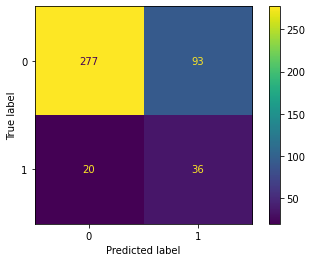

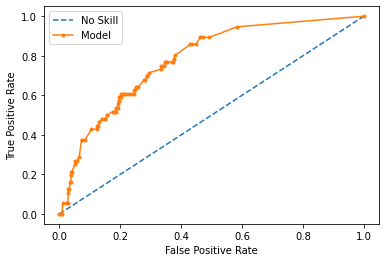

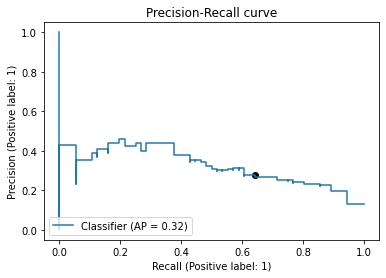

Diag: Specific Learning Disorder with Impairment in Reading


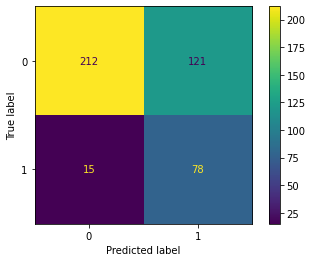

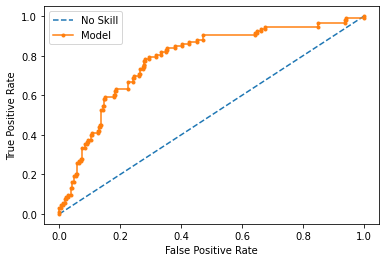

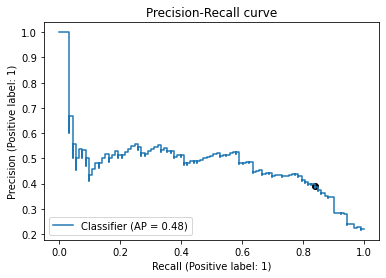

Diag: Oppositional Defiant Disorder


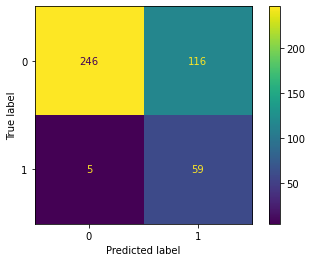

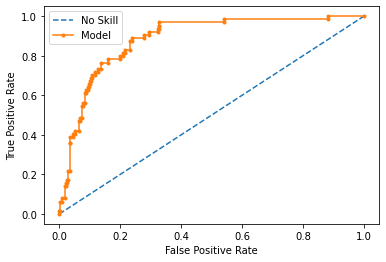

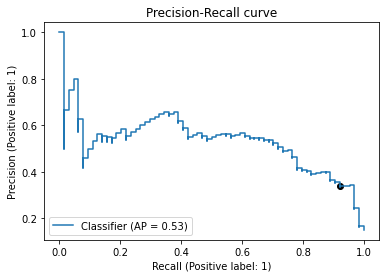

Diag: Specific Learning Disorder with Impairment in Mathematics


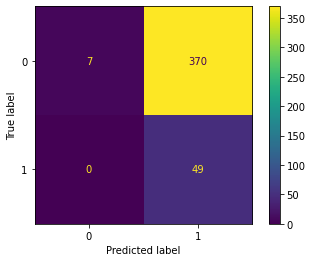

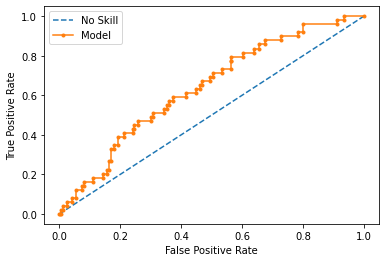

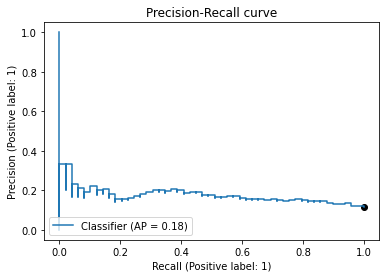

Diag: No Diagnosis Given


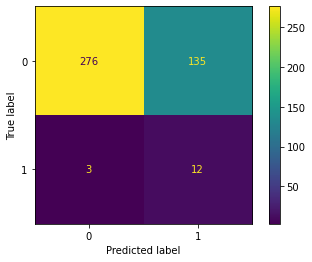

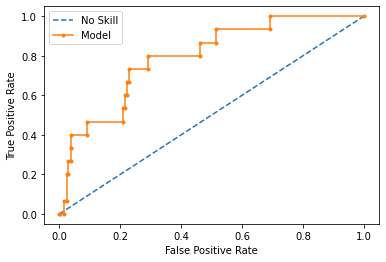

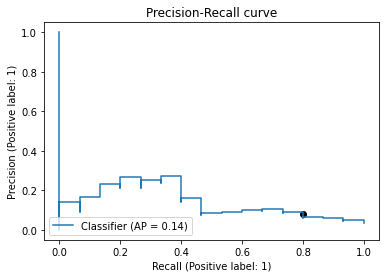

Diag: Major Depressive Disorder


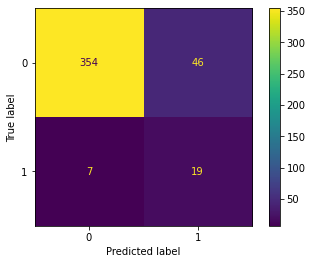

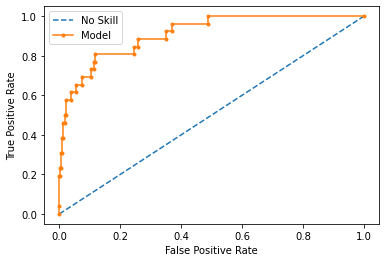

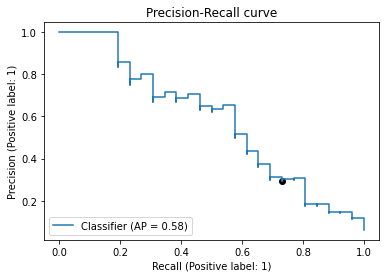

Diag: Enuresis


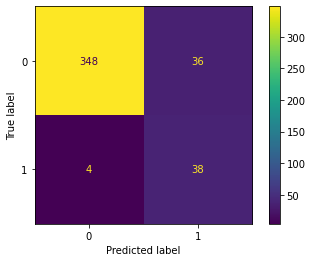

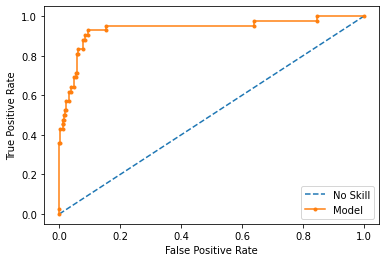

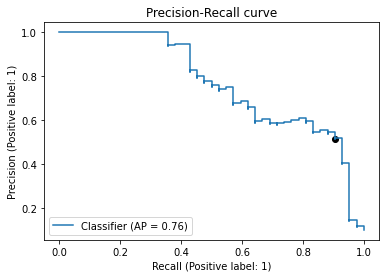

Diag: Generalized Anxiety Disorder


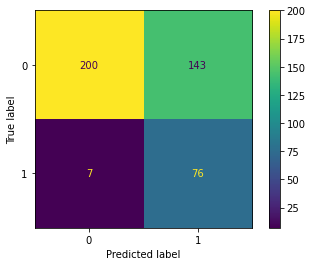

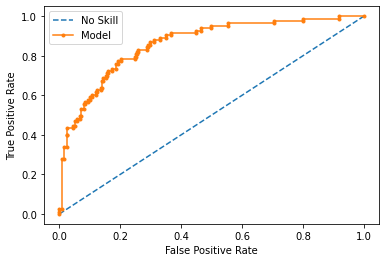

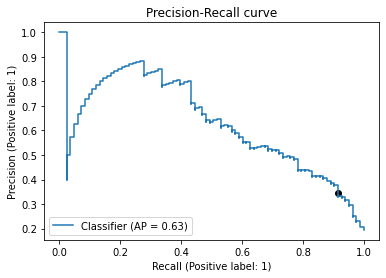

Diag: Social Anxiety (Social Phobia)


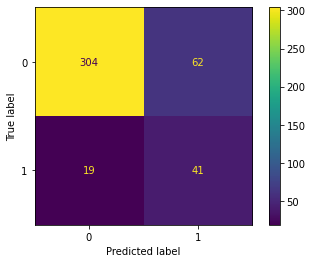

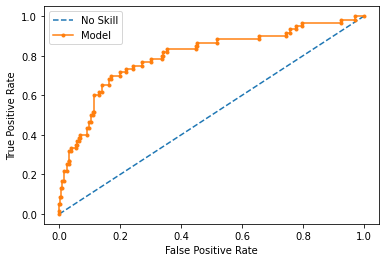

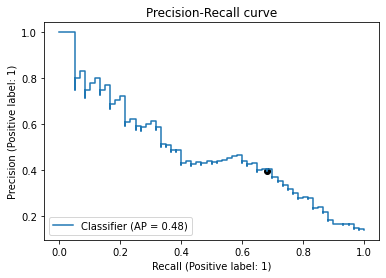

Diag: ADHD-Combined Type


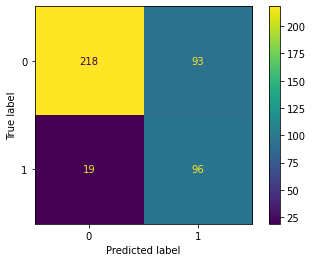

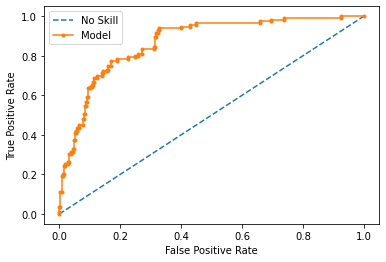

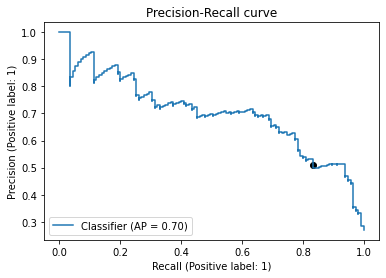

Diag: Language Disorder


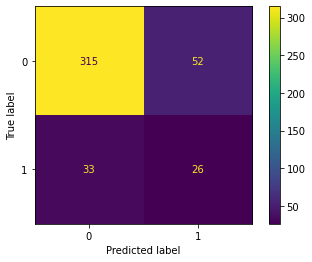

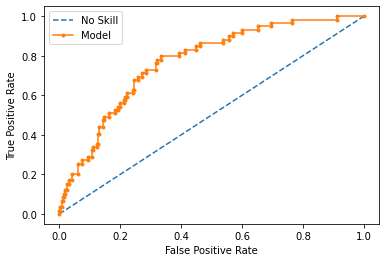

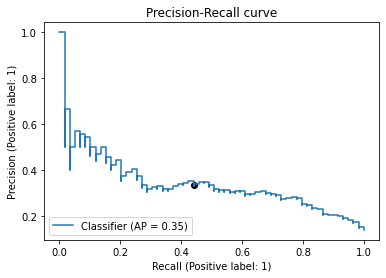

Diag: Separation Anxiety


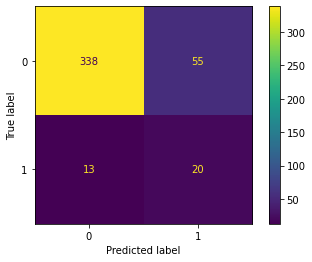

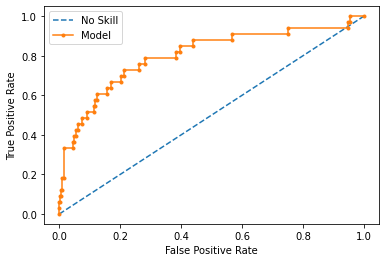

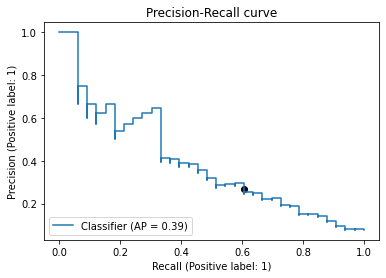

Diag: ADHD-Inattentive Type


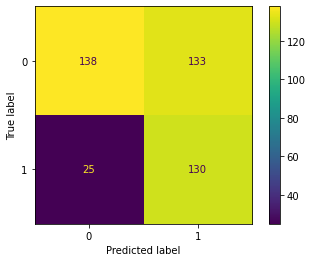

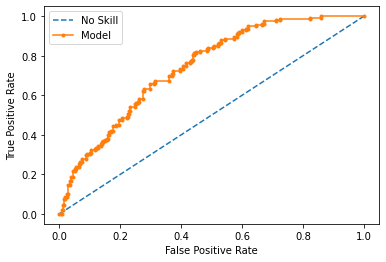

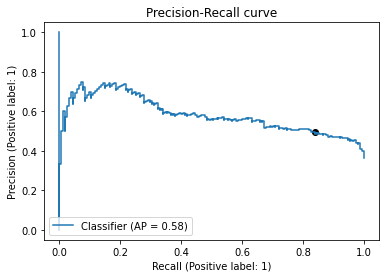

Diag: Autism Spectrum Disorder


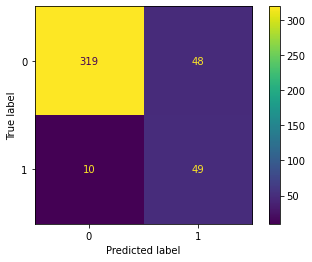

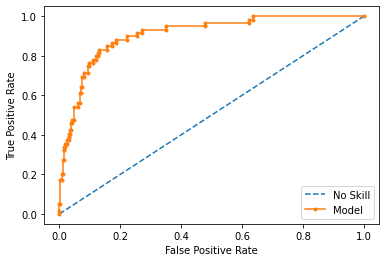

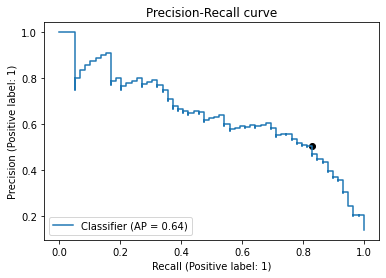

Diag: Specific Learning Disorder with Impairment in Written Expression


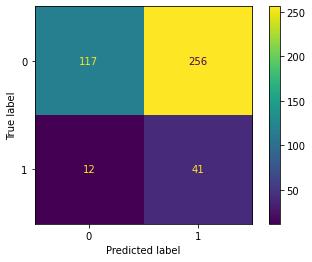

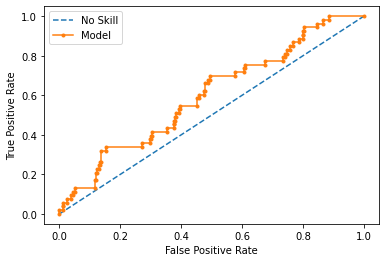

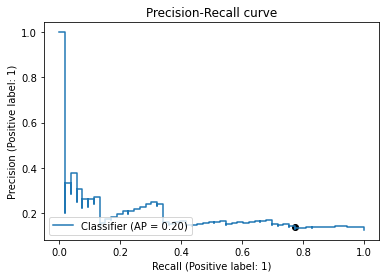

In [15]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in best_classifiers:
    
    print(diag)
    
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    X_test, y_test = datasets[diag]["X_test"], datasets[diag]["y_test"]
    metrics = get_metrics(classifier, threshold, X_test, y_test, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_test_set.append([
        diag, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])

In [16]:
restults_test_set_df[["Diag", "Recall (Sensitivity)", "TNR (Specificity)", "Predicted Positive Ratio", "ROC AUC"]].sort_values(by="ROC AUC", ascending=False)

,Diag,Recall (Sensitivity),TNR (Specificity),Predicted Positive Ratio,ROC AUC
6,Diag: Enuresis,0.90,0.91,0.17,0.94
5,Diag: Major Depressive Disorder,0.73,0.89,0.15,0.91
13,Diag: Autism Spectrum Disorder,0.83,0.87,0.23,0.91
2,Diag: Oppositional Defiant Disorder,0.92,0.68,0.41,0.88
9,Diag: ADHD-Combined Type,0.83,0.70,0.44,0.87
7,Diag: Generalized Anxiety Disorder,0.92,0.58,0.51,0.86
11,Diag: Separation Anxiety,0.61,0.86,0.18,0.80
8,Diag: Social Anxiety (Social Phobia),0.68,0.83,0.24,0.80
4,Diag: No Diagnosis Given,0.80,0.67,0.35,0.79
1,Diag: Specific Learning Disorder with Impairment in Reading,0.84,0.64,0.47,0.78


### Feature importance

In [17]:
if RUN_IMPORTANCES == 1:

    # Only use well performing diagnoses for feature selection: with (Mean CV AUC - CV AUC Std) > 0.65, F1 Beta > 0.5, and FPR < 0.6

    diags_with_good_performance = list(restults_val_set_df[((restults_val_set_df["ROC AUC Mean CV"] - restults_val_set_df["ROC AUC Std CV"])>0.65) & (restults_val_set_df["FBeta"] > 0.5)  & (restults_val_set_df["FPR"] < 0.6)]["Diag"]) 
    display(diags_with_good_performance)
    print(len(diags_with_good_performance), " / ", len(best_classifiers.keys()))
    print(set(best_classifiers.keys()) - set(diags_with_good_performance))

In [18]:
if RUN_IMPORTANCES == 1:
    if IMPORTANCES_FROM_FILE == 1:
        forward_feature_objects = {}
        try:
            forward_feature_objects = load('forward-sfs-cons-new-item-lvl.joblib')
        except Exception as e: print(e)

In [19]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["ROC AUC"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["ROC AUC"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

In [20]:
if RUN_IMPORTANCES == 1:
    
    from mlxtend.feature_selection import SequentialFeatureSelector

    if IMPORTANCES_FROM_FILE == 0:
        forward_feature_subsets = {}
        forward_feature_objects = {}
        for diag in diags_with_good_performance:
            print(diag)
            diag_classifier = best_classifiers[diag]

            cv = StratifiedKFold(n_splits=3)
            sfs = SequentialFeatureSelector(diag_classifier, 
                  k_features=100,
                  forward=True, 
                  scoring='roc_auc',
                  cv=cv,
                  n_jobs=-1)

            X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
            sfs = sfs.fit(X_train, y_train)

            forward_feature_subsets[diag] = sfs.subsets_
            forward_feature_objects[diag] = sfs

            analyze_importances(forward_feature_objects[diag].subsets_)

In [21]:
if RUN_IMPORTANCES == 1:
    # Save importances to file
    if IMPORTANCES_FROM_FILE == 0:
        dump(forward_feature_objects, 'forward-sfs-cons-new-item-lvl.joblib', compress=1)

In [22]:
if RUN_IMPORTANCES == 1:
    # Print sfs results
    for diag in forward_feature_objects:
        print(diag)

        features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[diag].subsets_)
        features_up_to_optimal = list(features_up_to_optimal)
        features_up_to_max_score = list(features_up_to_max_score)

        # Test both subsets on test set
        classifier = best_classifiers[diag]
        threshold = best_thresholds[diag]

        X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
        X_test, y_test = datasets[diag]["X_test"], datasets[diag]["y_test"]

        # All features
        # Create new pipeline with the same params (need to re-train the imputer on less features)
        new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
        new_classifier.fit(X_train, y_train)
        print("Score using all features: ")
        metrics = get_metrics(new_classifier, threshold, X_test, y_test, 1)
        print("ROC AUC: ", metrics[-1])
        print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
        print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
        print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
        print("Precision: ", metrics[metric_names.index("Precision")])
        print("FPR: ", metrics[metric_names.index("FPR")])

        # Create new pipeline with the same params (need to re-train the imputer on less features)
        new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
        new_classifier.fit(X_train[features_up_to_optimal], y_train)
        print("Performance on test set using optimal number of columns: ")
        metrics = get_metrics(new_classifier, threshold, X_test[features_up_to_optimal], y_test, 1)
        print("ROC AUC: ", metrics[-1])
        print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
        print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
        print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
        print("Precision: ", metrics[metric_names.index("Precision")])
        print("FPR: ", metrics[metric_names.index("FPR")])

        # Create new pipeline with the same params (need to re-train the imputer on less features)
        new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
        new_classifier.fit(X_train[features_up_to_max_score], y_train)
        print("Performance on test set using number of columns with maximum score")
        metrics = get_metrics(new_classifier, threshold, X_test[features_up_to_max_score], y_test, 1)
        print("ROC AUC: ", metrics[-1])
        print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
        print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
        print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
        print("Precision: ", metrics[metric_names.index("Precision")])
        print("FPR: ", metrics[metric_names.index("FPR")])